In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
%load_ext autoreload
%autoreload 2
import numpy as np
import time
import random
def print_np(x):
    print ("Type is %s" % (type(x)))
    print ("Shape is %s" % (x.shape,))
#     print ("Values are: \n%s" % (x))

In [2]:
import os
import sys
sys.path.append('../')

In [3]:
from model import UnicycleModel
from cost import UnicycleCost
from constraints import UnicycleConstraints
from scipy.integrate import solve_ivp
from matplotlib.patches import Ellipse
from utils.utils_alg import get_neighbor_vec,get_K_discrete
from utils.utils_plot import plot_traj,plot_traj_set,plot_state_input,plot_comparison

from trajopt import trajopt
from funlopt import funlopt
from Lipschitz import Lipschitz
from Scaling import TrajectoryScaling

from utils.utils_alg import get_sample_eta_w,propagate_model
import cvxpy as cvx
from scipy.integrate import solve_ivp



(CVXPY) Oct 20 10:35:12 AM: Encountered unexpected exception importing solver SCS:
ImportError("dlopen(/opt/anaconda3/envs/py309/lib/python3.9/site-packages/_scs_direct.cpython-39-darwin.so, 0x0002): Library not loaded: @rpath/liblapack.3.dylib\n  Referenced from: <F9700F1C-290B-3DF3-8D09-CFDF44BAE051> /opt/anaconda3/envs/py309/lib/python3.9/site-packages/_scs_direct.cpython-39-darwin.so\n  Reason: tried: '/opt/anaconda3/envs/py309/lib/python3.9/site-packages/../../liblapack.3.dylib' (no such file), '/opt/anaconda3/envs/py309/lib/python3.9/site-packages/../../liblapack.3.dylib' (no such file), '/opt/anaconda3/envs/py309/bin/../lib/liblapack.3.dylib' (no such file), '/opt/anaconda3/envs/py309/bin/../lib/liblapack.3.dylib' (no such file), '/usr/local/lib/liblapack.3.dylib' (no such file), '/usr/lib/liblapack.3.dylib' (no such file, not in dyld cache)")


In [4]:
N = 30
tf = 10
delT = tf/N

## obstacle setting

In [5]:
def get_H_obs(rx,ry) :
    return np.diag([1/rx,1/ry])
# obstacle
c_list = []
H_list = []


c_list.append([1.8,0.3])
H_list.append(get_H_obs(0.5,0.5))

c_list.append([2*2/3,3.5])
H_list.append(get_H_obs(0.5,0.5))

c_list.append([4.2,0.7])
H_list.append(get_H_obs(0.5,0.5))
c_list.append([3.8,3.5])
H_list.append(get_H_obs(0.5,0.5))

c_list.append([10*2/3,0.5])
H_list.append(get_H_obs(0.5,0.5))
c_list.append([6.5,4])
H_list.append(get_H_obs(0.5,0.5))



c_list.append([4*2/3,1.7])
H_list.append(get_H_obs(0.5,0.5))
c_list.append([8*2/3,2.3])
H_list.append(get_H_obs(0.5,0.5))

c_list.append([0.5,2])
H_list.append(get_H_obs(0.5,0.5))
c_list.append([8,2.3])
H_list.append(get_H_obs(0.5,0.5))


## initial and final conditions 

In [6]:
myModel = UnicycleModel.unicycle1('unicycle','numeric_central')

ix = myModel.ix
iu = myModel.iu
iw = myModel.iw
iq = myModel.iq
ip = myModel.ip

C = myModel.C
D = myModel.D
E = myModel.E
G = myModel.G

myCost = UnicycleCost.unicycle('Hello',ix,iu,N)
myConst = UnicycleConstraints.UnicycleConstraints('Hello',ix,iu)
myConst.set_obstacle(c_list,H_list)



In [7]:
xi = np.zeros(3)
xi[0] = 0.0
xi[1] = 0.0 
xi[2] = 0

xf = np.zeros(3)
xf[0] = 8.0
xf[1] = 4.0
xf[2] = 0

Qini = np.diag([0.4**2,0.4**2,np.deg2rad(20)**2])
Qf = np.diag([0.3**2,0.3**2,np.deg2rad(20)**2])

x0 = np.zeros((N+1,ix))
for i in range(N+1) :
    x0[i] = (N-i)/N * xi + i/N * xf
u0 = np.zeros((N+1,iu))

In [8]:
A,B,s,z,x_prop_n = myModel.diff_discrete_zoh(x0[0:N,:],u0[0:N,:],delT,tf) 
S = np.eye(ix)
R = 1*np.eye(iu)
K0 = get_K_discrete(A,B,S,R,S,N,ix,iu)
Q0 = np.tile(np.diag([0.35**2,0.35**2,np.deg2rad(10)**2]),(N+1,1,1))
Y0 = K0@Q0[:N]
betahat = np.ones(N+1)

In [9]:
x_max = np.array([10,10,np.pi])
x_min = np.zeros(ix)

u_max = np.array([5,5]) 
u_min = np.zeros(iu)

traj_scaling = TrajectoryScaling(x_min,x_max,u_min,u_max,tf)

x_max = np.array([1,1,np.pi])
x_min = np.zeros(ix)

u_max = np.array([5,5]) 
u_min = np.zeros(iu)

funl_scaling = TrajectoryScaling(x_min,x_max,u_min,u_max,tf)

In [10]:
traj_solver= trajopt('unicycle',N,tf,10,myModel,myCost,myConst,Scaling=traj_scaling,
              w_c=1,w_vc=1e3,w_tr=1e0,tol_vc=1e-6,tol_tr=1e-4,tol_dyn=1e-3,verbosity=True)

Is DPP?  True


In [11]:
_,_,xnom,unom,_,total_num_iter,_,_,_,_,history_nom = traj_solver.run(x0,u0,xi,xf)
tnom = np.array(range(N+1))*delT

Set parameter Username
Academic license - for non-commercial use only - expires 2023-11-07
┌──────────────────────────────────────────────────────────────────────────────────────────────┐

│                                              ..:: SCP ::..                                   │

├──────┬───────────┬──────────┬─────────┬───────────┬────────────┬─────────┬─────────┬─────────┤

│ iter │  total    │ final    │ input   │     -     │ total cost │ vc      │ tr      │ dyn     │

│      │  cost     │ time [s] │ energy  │     -     │ reduction  │ (log10) │         │         │

├──────┼───────────┼──────────┼─────────┼───────────┼────────────┼─────────┼─────────┼─────────┤

│1     │4019.969   │10.000    │19.2     │0          │-4.02e+03   │0(0.60  )│0(0.769 )│0(0.354 )│
│2     │22.035     │10.000    │21.1     │0          │4e+03       │1(-13.71)│0(0.912 )│0(0.059 )│
│3     │26.181     │10.000    │26.2     │0          │-4.15       │1(-13.71)│0(0.031 )│0(0.004 )│
│4     │26.235     │10.000    

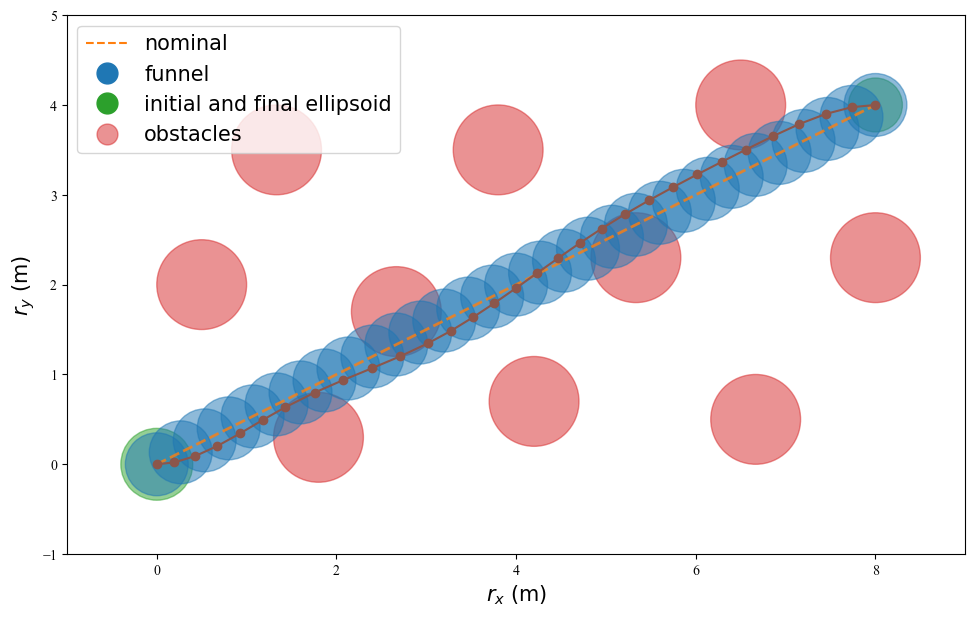

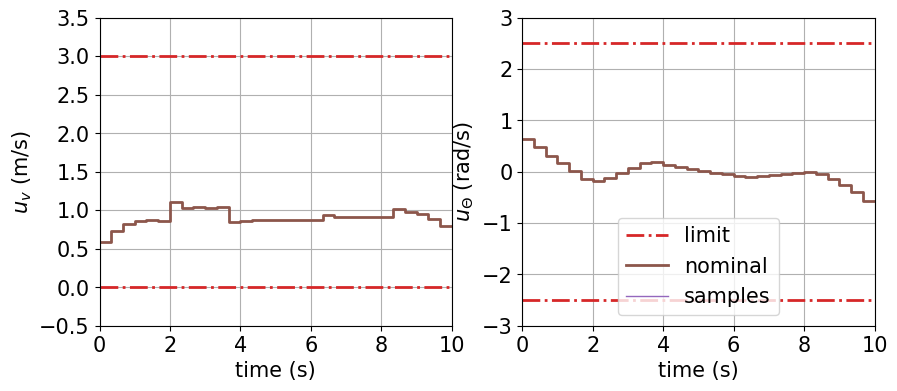

In [12]:
fS = 15
plt.figure(0,figsize=(15,7))
plot_traj_set(x0,u0,c_list,H_list,Q0,xi=xi,xf=xf,Qi=Qini,Qf=Qf,plt=plt)
plt.plot(xnom[:,0],xnom[:,1],'o-',color='tab:brown',label='traj w/o funnel')
plt.axis([-1.0, 9.0, -1.0, 5.0])
plt.figure(1,figsize=(10,4))
plt.subplot(121)
plt.plot(tnom, unom[:,0]*0+myConst.vmax,'-.',color='tab:red',alpha=1.0,linewidth=2.0,label='limit')
plt.plot(tnom, unom[:,0]*0+myConst.vmin,'-.',color='tab:red',alpha=1.0,linewidth=2.0)
plt.step(tnom, [*unom[:N,0],unom[N-1,0]],'-',color='tab:brown',alpha=1.0,where='post',linewidth=2.0,label='nominal')
plt.plot(1e3, 1e3,'-',color='tab:purple',alpha=1.0,linewidth=1.0,label='samples')
plt.xlabel('time (s)', fontsize = fS)
plt.ylabel('$u_v$ (m/s)', fontsize = fS)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.axis([0.0, tf, -0.5, 3.5])
plt.grid(True)

plt.subplot(122)
plt.plot(tnom, unom[:,1]*0+myConst.wmax,'-.',color='tab:red',alpha=1.0,linewidth=2.0)
plt.plot(tnom, unom[:,1]*0+myConst.wmin,'-.',color='tab:red',alpha=1.0,linewidth=2.0,label='limit')
plt.step(tnom, [*unom[:N,1],unom[N-1,1]],'-',color='tab:brown',alpha=1.0,where='post',linewidth=2.0,label='nominal')
plt.plot(1e3, 1e3,'-',color='tab:purple',alpha=1.0,linewidth=1.0,label='samples')
plt.xlabel('time (s)', fontsize = fS)
plt.ylabel('$u_{\Theta}$ (rad/s)', fontsize = fS)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.axis([0.0, tf, -3, 3])
plt.legend(fontsize=fS)
plt.rcParams["font.family"] = "Times New Roman"
plt.grid(True)

## run

In [13]:
total_iter = 20

tol_funl = 1e-8
tol_traj = 1e-8
tol_vc = 1e-8
tol_dyn = 1e-8

traj_solver= trajopt('unicycle',N,tf,10,myModel,myCost,myConst,Scaling=traj_scaling,
              w_c=1,w_vc=1e3,w_tr=1e0,tol_vc=1e-6,tol_tr=1e-4,tol_dyn=1e-3,verbosity=False)

funl_solver = funlopt(ix,iu,iq,ip,iw,N,myCost.S,myCost.R,funl_scaling,
                      alpha=0.99,
                      lambda_mu=0.1,
                      w_tr=1e-4,
                      flag_nonlinearity=True)
funl_solver.cvx_initialize(Qini,Qf)
lip_estimator = Lipschitz(ix,iu,iq,ip,iw,N,num_sample=100,flag_uniform=True)

from jointsynthesis import jointsynthesis
JS = jointsynthesis(myModel,traj_solver,funl_solver,lip_estimator,total_iter,
                   tol_traj,tol_funl,tol_vc,tol_dyn,verbosity=True)

Is DPP?  True
nonlinear funnel
Is DPP?  True


In [14]:
history = JS.run(xi,xf,x0,u0,Q0,Y0,K0)

|iter| traj_cost | funl_cost |   vc   |   Delta_T   |   Delta_F   | e_prop  |gamma diff|
|    |           |           | log10  |   log10     |   log10     | log10   |          |
|1   |46.648     |4.102      |-13.4(1)|1.78      (0)|2.41      (0)|-3.967(0)|1.38826342|
|2   |36.114     |4.326      |-13.4(1)|0.716     (0)|0.313     (0)|-3.982(0)|0.45256947|
|3   |37.083     |4.490      |-12.8(1)|0.352     (0)|-0.0189   (0)|-3.145(0)|0.05830539|
|4   |37.637     |4.534      |-13.6(1)|-0.527    (0)|-0.702    (0)|-4.121(0)|0.05511445|
|5   |37.641     |4.528      |-11.9(1)|-1.41     (0)|-1.65     (0)|-4.834(0)|0.01839330|
|6   |37.476     |4.520      |-12  (1)|-1.75     (0)|-1.82     (0)|-4.141(0)|0.00498352|
|7   |37.450     |4.520      |-11.6(1)|-2.79     (0)|-2.74     (0)|-4.117(0)|0.00430067|
|8   |37.446     |4.518      |-13.4(1)|-2.98     (0)|-3.29     (0)|-4.500(0)|0.00152769|
|9   |37.455     |4.516      |-11.3(1)|-2.99     (0)|-3.25     (0)|-4.659(0)|0.00095077|
|10  |37.470     |4.5

In [17]:
del_traj_list = [history[i]['traj_diff'] for i in range(len(history))]
del_funl_list = [history[i]['funl_diff'] for i in range(len(history))]
vc_list = [history[i]['vc'] for i in range(len(history))]
dyn_error_list = [history[i]['dyn_error'] for i in range(len(history))]

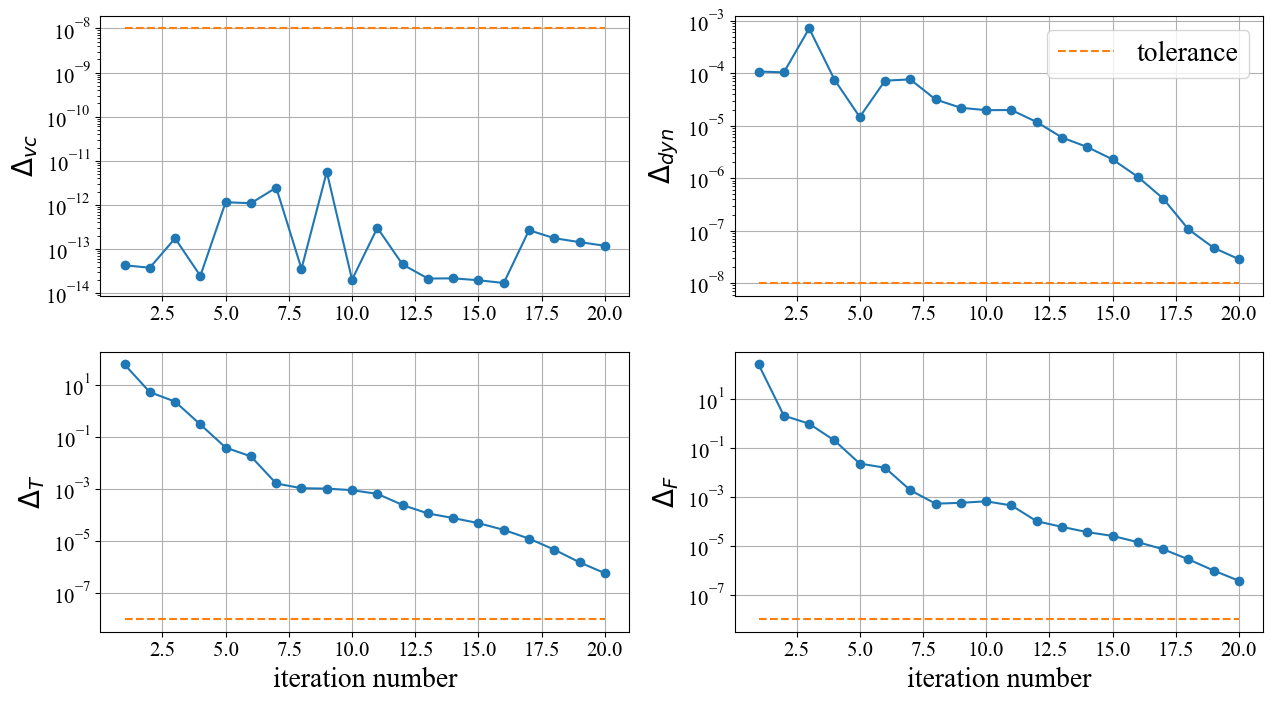

In [18]:
i_index = np.array([i+1 for i in range(len(history))])
fS = 20
plt.figure(figsize=(15,8))
plt.subplot(221)
plt.plot(i_index,vc_list,'o-')
plt.plot(i_index,i_index*0+tol_vc,'--')
# plt.xlabel('iteration number',fontsize=fS,fontname='Times New Roman')
plt.ylabel(r'$\Delta_{vc}$',fontsize=fS,fontname='Times New Roman')
plt.yscale('log')
# plt.ylim([10**(-6), 10**(4)])
plt.grid(True)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

plt.subplot(222)
plt.plot(i_index,dyn_error_list,'o-')
plt.plot(i_index,i_index*0+tol_dyn,'--',label='tolerance')
# plt.xlabel('iteration number',fontsize=fS,fontname='Times New Roman')
plt.ylabel(r'$\Delta_{dyn}$',fontsize=fS,fontname='Times New Roman')
plt.yscale('log')
# plt.ylim([10**(-6), 10**(4)])
plt.grid(True)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(fontsize=fS)


plt.subplot(223)
plt.plot(i_index,del_traj_list,'o-')
plt.plot(i_index,i_index*0+tol_traj,'--')
plt.xlabel('iteration number',fontsize=fS,fontname='Times New Roman')
plt.ylabel(r'$\Delta_T$',fontsize=fS,fontname='Times New Roman')
plt.yscale('log')
# plt.ylim([10**(-6), 10**(4)])
plt.grid(True)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

plt.subplot(224)
plt.plot(i_index,del_funl_list,'o-')
plt.plot(i_index,i_index*0+tol_funl,'--')
plt.xlabel('iteration number',fontsize=fS,fontname='Times New Roman')
plt.ylabel(r'$\Delta_F$',fontsize=fS,fontname='Times New Roman')
plt.yscale('log')
# plt.ylim([10**(-6), 10**(4)])
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.rcParams["font.family"] = "Times New Roman"
plt.grid(True)

# Computational time

In [19]:
time_derivs = []
time_trajopt = []
time_funlopt = []
time_lipschitz = []

for his in history :
    time_derivs.append(his['t_derivs'])
    time_trajopt.append(his['t_trajopt'])
    time_funlopt.append(his['t_funlopt'])
    time_lipschitz.append(his['t_Lipschitz'])
def mean_list(l) :
    return sum(l)/len(l)
mean_derivs = mean_list(time_derivs)
mean_trajopt = mean_list(time_trajopt)
mean_funlopt = mean_list(time_funlopt)
mean_lipschitz = mean_list(time_lipschitz)
print("mean_derivs",mean_derivs)
print("mean_trajopt",mean_trajopt)
print("mean_funlopt",mean_funlopt)
print("mean_lipschitz",mean_lipschitz)

mean_derivs 0.006627392768859863
mean_trajopt 0.04366768598556518
mean_funlopt 4.300241458415985
mean_lipschitz 1.2100791335105896


# Evaluate the generated traj and funl

In [20]:
from utils.utils_alg import forward_full_with_K,get_sample_trajectory
import scipy

In [21]:
xbar = history[-1]['x']
ubar = history[-1]['u']
Qbar = history[-1]['Q']
Ybar = history[-1]['Y']
Kbar = history[-1]['K']

(-1.0, 9.0, -1.0, 5.0)

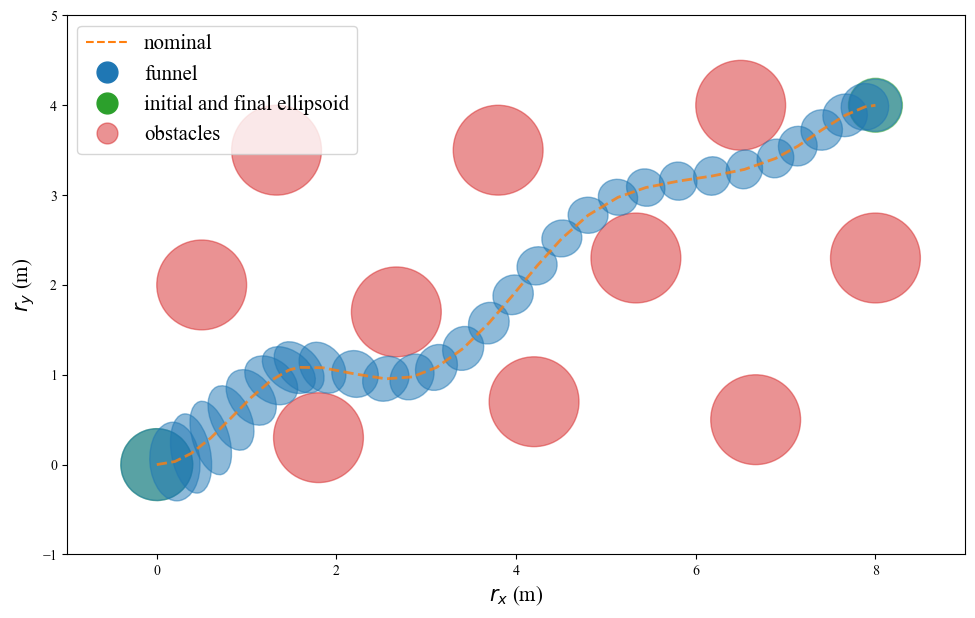

In [22]:
fS = 15
plt.figure(0,figsize=(15,7))
plot_traj_set(xbar,ubar,c_list,H_list,Qbar,xi=xi,xf=xf,Qi=Qini,Qf=Qf,plt=plt)
plt.legend(fontsize=fS)
plt.rcParams["font.family"] = "Times New Roman"
plt.axis([-1.0, 9.0, -1.0, 5.0])

# comparison with linear case

In [23]:
traj_solver= trajopt('unicycle',N,tf,10,myModel,myCost,myConst,Scaling=traj_scaling,
              w_c=1,w_vc=1e3,w_tr=1e0,tol_vc=1e-6,tol_tr=1e-4,tol_dyn=1e-3,verbosity=False)

funl_solver = funlopt(ix,iu,iq,ip,iw,N,myCost.S,myCost.R,funl_scaling,
                      alpha=0.99,
                      lambda_mu=0.1,
                      w_tr=1e-4,
                      flag_nonlinearity=False)
funl_solver.cvx_initialize(Qini,Qf)
lip_estimator = Lipschitz(ix,iu,iq,ip,iw,N,num_sample=100,flag_uniform=True)

from jointsynthesis import jointsynthesis
JS = jointsynthesis(myModel,traj_solver,funl_solver,lip_estimator,total_iter,
                   tol_traj,tol_funl,tol_vc,tol_dyn,verbosity=True)

Is DPP?  True
linear funnel
Is DPP?  True


In [24]:
history_linear = JS.run(xi,xf,x0,u0,Q0,Y0,K0)

|iter| traj_cost | funl_cost |   vc   |   Delta_T   |   Delta_F   | e_prop  |gamma diff|
|    |           |           | log10  |   log10     |   log10     | log10   |          |
|1   |46.648     |3.535      |-13.4(1)|1.78      (0)|2.4       (0)|-3.967(0)|1.38826342|
|2   |34.980     |3.748      |-13.1(1)|0.759     (0)|0.259     (0)|-3.933(0)|0.52851185|
|3   |35.646     |3.766      |-13.2(1)|-0.595    (0)|-1.05     (0)|-4.129(0)|0.04991880|
|4   |35.666     |3.766      |-13.7(1)|-2.57     (0)|-2.84     (0)|-3.926(0)|0.01377823|
|5   |35.675     |3.767      |-13.2(1)|-3.08     (0)|-3.34     (0)|-4.562(0)|0.00093795|
|6   |35.675     |3.768      |-13.7(1)|-3.45     (0)|-3.82     (0)|-4.732(0)|0.00097719|
|7   |35.673     |3.768      |-13.7(1)|-3.8      (0)|-4.08     (0)|-5.084(0)|0.00061398|
|8   |35.671     |3.768      |-13.6(1)|-4.27     (0)|-4.58     (0)|-5.557(0)|0.00043139|
|9   |35.669     |3.768      |-13.7(1)|-4.85     (0)|-5.11     (0)|-6.131(0)|0.00023469|
|10  |35.667     |3.7

In [25]:
xbar_linear = history_linear[-1]['x']
ubar_linear = history_linear[-1]['u']
Qbar_linear = history_linear[-1]['Q']
Ybar_linear = history_linear[-1]['Y']
Kbar_linear = history_linear[-1]['K']

(array([-1.,  0.,  1.,  2.,  3.,  4.,  5.]),
 [Text(0, -1.0, '−1'),
  Text(0, 0.0, '0'),
  Text(0, 1.0, '1'),
  Text(0, 2.0, '2'),
  Text(0, 3.0, '3'),
  Text(0, 4.0, '4'),
  Text(0, 5.0, '5')])

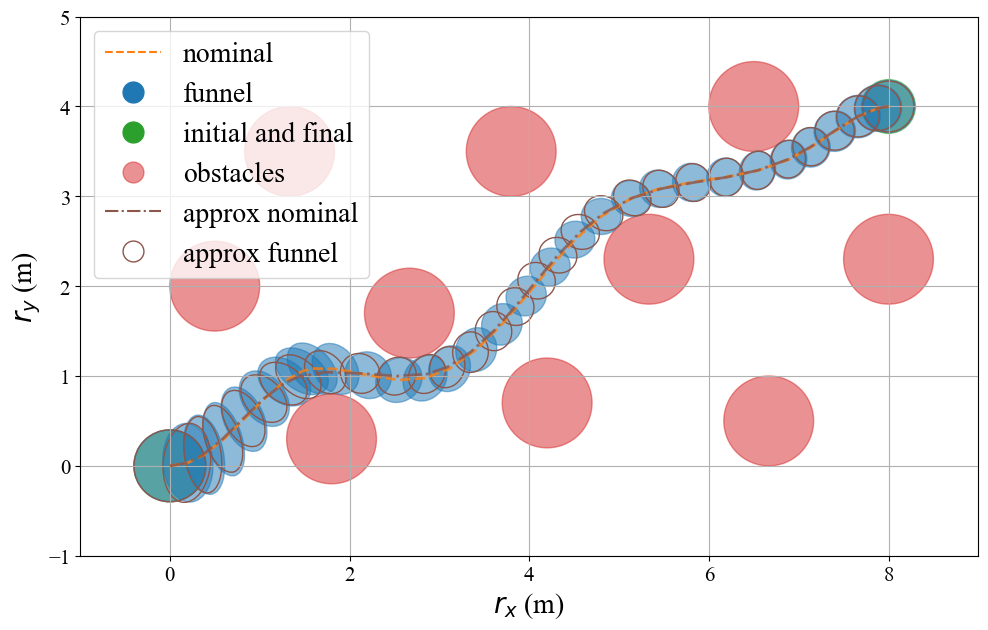

In [26]:
fS = 20
plt.figure(0,figsize=(15,7))
plot_comparison(xbar,xbar_linear,c_list,H_list,Qbar,Qbar_linear,xi=xi,xf=xf,Qi=Qini,Qf=Qf,plt=plt,fS=fS)
plt.legend(fontsize=fS)
plt.grid(True)
plt.rcParams["font.family"] = "Times New Roman"
plt.axis([-1.0, 9.0, -1.0, 5.0])
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

# Sample from initial set

In [27]:
x0_sample = []
num_sample = 100
for i in range(num_sample) :
    z = np.random.randn(ix)
    z = z / np.linalg.norm(z)
    x_s = xbar[0] + scipy.linalg.sqrtm(Qbar[0])@z
    x0_sample.append(x_s)
tsam,xsam,usam,wsam,xsamp = get_sample_trajectory(xi,x0_sample,xbar,ubar,Qbar,Ybar,myModel,N,ix,iu,iw,delT,
                                            flag_noise=True)

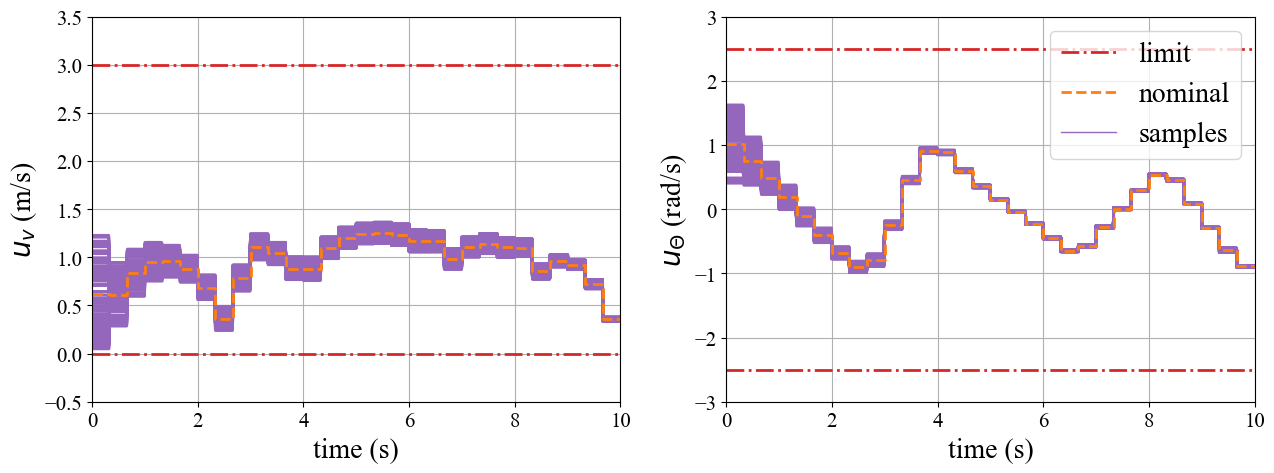

In [28]:
fS = 20
plt.figure(0,figsize=(15,5))
alpha = 1.0
t_index = np.array(range(N+1))*delT
for i in range(num_sample) :
    tsam_e = tsam[i]
    xsam_e = xsam[i]
    usam_e = usam[i]
#     plot_state_input(tsam_e,xsam_e,usam_e,None,None,N,delT,alpha,plt,flag_step=False)

    plt.subplot(121)
    plt.plot(tsam_e, usam_e[:,0],color='tab:purple',alpha=alpha,linewidth=2.0)
    plt.subplot(122)
    plt.plot(tsam_e, usam_e[:,1],color='tab:purple',alpha=alpha,linewidth=2.0)
plt.subplot(121)
plt.plot(tsam_e, usam_e[:,0]*0+myConst.vmax,'-.',color='tab:red',alpha=1.0,linewidth=2.0,label='limit')
plt.plot(tsam_e, usam_e[:,0]*0+myConst.vmin,'-.',color='tab:red',alpha=1.0,linewidth=2.0)
plt.step(t_index, [*ubar[:N,0],ubar[N-1,0]],'--',color='tab:orange',alpha=1.0,where='post',linewidth=2.0,label='nominal')
plt.plot(1e3, 1e3,'-',color='tab:purple',alpha=1.0,linewidth=1.0,label='samples')
plt.xlabel('time (s)', fontsize = fS)
plt.ylabel('$u_v$ (m/s)', fontsize = fS)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.axis([0.0, tf, -0.5, 3.5])
plt.grid(True)
plt.subplot(122)
plt.plot(tsam_e, usam_e[:,1]*0+myConst.wmax,'-.',color='tab:red',alpha=1.0,linewidth=2.0)
plt.plot(tsam_e, usam_e[:,1]*0+myConst.wmin,'-.',color='tab:red',alpha=1.0,linewidth=2.0,label='limit')
plt.step(t_index, [*ubar[:N,1],ubar[N-1,1]],'--',color='tab:orange',alpha=1.0,where='post',linewidth=2.0,label='nominal')
plt.plot(1e3, 1e3,'-',color='tab:purple',alpha=1.0,linewidth=1.0,label='samples')
plt.xlabel('time (s)', fontsize = fS)
plt.ylabel('$u_{\Theta}$ (rad/s)', fontsize = fS)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.axis([0.0, tf, -3, 3])
plt.legend(fontsize=fS)
plt.rcParams["font.family"] = "Times New Roman"
plt.grid(True)


## sample from approx funnel

In [29]:
x0_sample = []
for i in range(num_sample) :
    z = np.random.randn(ix)
    z = z / np.linalg.norm(z)
    x_s = xbar_linear[0] + scipy.linalg.sqrtm(Qbar_linear[0])@z
    x0_sample.append(x_s)
tsam_linear,xsam_linear,usam_linear,wsam_linear,xsamp_linear = get_sample_trajectory(xi,x0_sample,
                                                                    xbar_linear,ubar_linear,
                                                                    Qbar_linear,Ybar_linear,myModel,N,ix,iu,iw,delT,
                                                                    flag_noise=True)

there is invariance violation
there is invariance violation
there is invariance violation
there is invariance violation
there is invariance violation
there is invariance violation
there is invariance violation
there is invariance violation
there is invariance violation
there is invariance violation
there is invariance violation
there is invariance violation
there is invariance violation


In [30]:
def get_radii_list(xsamp,xbar,Qbar) :
    radii_list = []
    for x in xsamp :
        radii = np.zeros(N+1)
        for i in range(N+1) :
            radii[i] = (x[i]-xbar[i]).T@np.linalg.inv(Qbar[i])@(x[i]-xbar[i])
            if radii[i] > 1 + 1e-8 :
                print("invariance violation",radii[i])
        radii_list.append(radii)
    return radii_list
radii_list = get_radii_list(xsamp,xbar,Qbar)
radii_list_linear = get_radii_list(xsamp_linear,xbar_linear,Qbar_linear)

invariance violation 1.031923149264168
invariance violation 1.0691251087995788
invariance violation 1.0951413139515542
invariance violation 1.102690624403196
invariance violation 1.0740118385961601
invariance violation 1.0138742810885806
invariance violation 1.0333710764533401
invariance violation 1.0207793790642306
invariance violation 1.0579009213029447
invariance violation 1.0522936482517822
invariance violation 1.0050695476500227
invariance violation 1.0145152624693556
invariance violation 1.0093191565661765


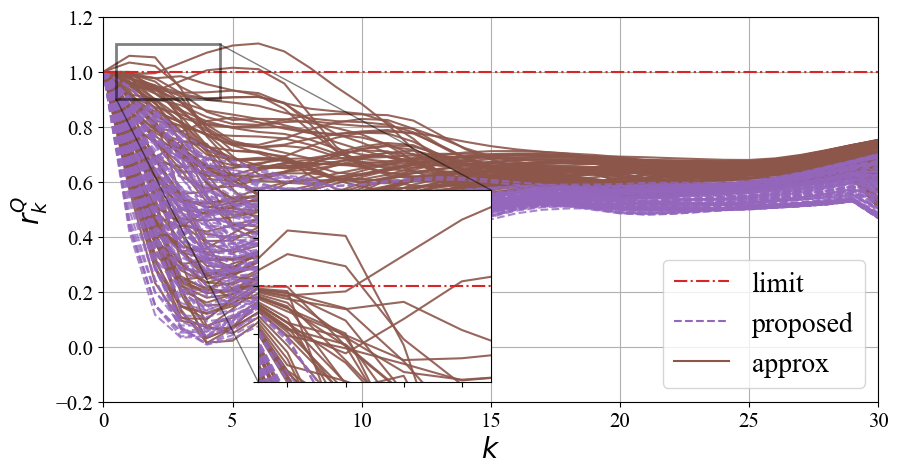

In [31]:
fS = 20
idx_plot = [i for i in range(N+1)]
fig, ax = plt.subplots(figsize=[10, 5])
for radii in radii_list_linear :
    ax.plot(idx_plot,radii,color='tab:brown',alpha=0.9)
for radii in radii_list :
    ax.plot(idx_plot,radii,'--',color='tab:purple',alpha=0.8)
ax.plot(idx_plot,radii*0+1,'-.',color='tab:red',alpha=1.0,label='limit')
plt.xlabel('$k$', fontsize = fS)
plt.ylabel('$r^Q_k$', fontsize = fS)
plt.grid(True)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.axis([0,30,-0.2,1.2])
plt.plot(1e3,1e3,'--',color='tab:purple',alpha=1.0,label='proposed')
plt.plot(1e3,1e3,color='tab:brown',alpha=1.0,label='approx')
plt.legend(fontsize=fS)
# axins = ax.inset_axes([5, 15, 0.0, 0.6])
axins = ax.inset_axes([0.2, 0.05, 0.3, 0.5])

for radii in radii_list_linear :
    axins.plot(idx_plot,radii,color='tab:brown',alpha=0.9)
for radii in radii_list :
    axins.plot(idx_plot,radii,'--',color='tab:purple',alpha=0.8)
axins.plot(idx_plot,radii*0+1,'-.',color='tab:red',alpha=1.0,label='limit')

axins.set_xlim(0.5, 4.5)
axins.set_ylim(0.9, 1.1)
axins.set_xticklabels([])
axins.set_yticklabels([])
ax.indicate_inset_zoom(axins, edgecolor="black",linewidth=2.0)
plt.grid(True)
plt.rcParams["font.family"] = "Times New Roman"

In [32]:
for idx in range(len(history)+1) :
    if idx == 0 :
        xnew,unew,Qnew = x0,u0,Q0
    else :
        xnew,unew,Qnew = history[idx-1]['x'],history[idx-1]['u'],history[idx-1]['Q']

    plt.figure(figsize=(7,7))
    plt.rcParams["font.family"] = "Times New Roman"
    plt.rcParams["legend.loc"] = 'upper left'
    plot_traj_set(xnew,unew,c_list,H_list,Qnew,xi=xi,xf=xf,Qi=Qini,Qf=Qf,plt=plt)
    plt.title(str(idx)+' iterations',fontsize=15)
    plt.axis([-1.0, 9.0, -1.0, 5.0])
    # plt.savefig('../images/iteration/cluttered/'+str(idx)+'.png',dpi=500)
    plt.close()